In [3]:
# !pip3 install seaborn
# !pip3 install matplotlib
import seaborn as sns
from collections import defaultdict
import pandas as pd
import matplotlib
from pathlib import Path
from matplotlib import pyplot as plt

In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
from scipy.spatial.distance import cosine
import numpy as np
import re
import string
cos = torch.nn.CosineSimilarity(dim=0)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

# Сбор предложений и предпроцессинг

In [5]:
def corpus_to_sent(corpus):
    with open(corpus, encoding='utf-8') as f:
        reader = f.read().split('# sent_id = ')
    return reader

In [6]:
sents = corpus_to_sent('ru_syntagrus-ud-dev.conllu.txt')

sent_list = []
for sent in sents[1:10]:
    s = sent.split('\n')[1].strip('# text = ')
    s = " ".join(re.findall('[a-zA-Zа-яА-яёЁ]+', s))
    print(s)
    sent_list.append(s) #список предложений без знаков препинания

sent_list[8]

Алгоритм от имени учёного аль Хорезми точный набор инструкций описывающих порядок действий исполнителя для достижения результата решения задачи за конечное время
В старой трактовке вместо слова порядок использовалось слово последовательность но по мере развития параллельности в работе компьютеров слово последовательность стали заменять более общим словом порядок
Это связано с тем что работа каких то инструкций алгоритма может быть зависима от других инструкций или результатов их работы
Таким образом некоторые инструкции должны выполняться строго после завершения работы инструкций от которых они зависят
Независимые инструкции или инструкции ставшие независимыми из за завершения работы инструкций от которых они зависят могут выполняться в произвольном порядке параллельно или одновременно если это позволяют используемые процессор и операционная система
Ранее часто писали алгорифм сейчас такое написание используется редко но тем не менее имеет место например Нормальный алгорифм Маркова
Час

'Единого истинного определения понятия алгоритм нет'

# Деревья

In [7]:
def ud_to_tree(lines):
        
    colons = [l.split('\t') for l in lines[:-2] if l != '' and l[0].isdigit()]

    words = [c[0] + '_'+ c[1] for c in colons]

    tree = [('0_root', [])]
    for w in words:
        tree.append((w, []))
  
    for c in colons:
        if c[6] != '_': # проверка на эллипсис
            tree[int(c[6])][1].append(tree[int(c[0])]) #[i + 1])
        else:
            return False
    
    return tree

In [8]:
trees = []
sents = corpus_to_sent('ru_syntagrus-ud-dev.conllu.txt')
sent_list = []
data = []

for sent in sents[1:]:
    lines = sent.split('\n')[2:]
    if ud_to_tree(lines):
        trees.append(ud_to_tree(lines))
        s = sent.split('\n')[1].strip('# text = ')
        if re.search('[a-zA-Z]+', s) is None: # проверка на иностранные слова
            if re.search('\d+', s) is None: # проверка на даты
                s = " ".join(re.findall('[а-яА-яёЁ]+', s))
                sent_list.append(s)
                data.append([s, ud_to_tree(lines)])

In [9]:
len(trees) # всего предложений(деревьев) в файле без учета предложений с эллипсисом

8688

In [10]:
len(sent_list) # список предложений уже без знаков препинания, которые не содержат латиницу, даты и эллипсис

5643

In [11]:
len(data) # предложение и его дерево

5643

8906 предожений всего в файле корпуса СинТагРус

8688 предложений если без эллипсиса, что подтверждает информацию из описательной статьи по корпусу "Предложения с эллипсисом составляют 2–3 процента от общего числа предложений корпуса СинТагРус."
(пример - 103 предложение)

In [12]:
data[800][1][0][1][0]

('3_вернулся',
 [('1_Он', []),
  ('2_снова', []),
  ('4_памятью', []),
  ('6_ссоре', [('5_к', [])]),
  ('8_подумал',
   [('7_и', []),
    ('19_подозревала',
     [('9_,', []),
      ('10_что', []),
      ('11_жена', [('12_,', [])]),
      ('14_общем', [('13_в', []), ('15_,', [])]),
      ('16_ничего', []),
      ('17_и', []),
      ('18_не', []),
      ('20_всерьез', []),
      ('26_знала',
       [('21_,', []),
        ('22_что', []),
        ('23_она', []),
        ('25_точно', [('24_даже', [])]),
        ('32_едет',
         [('27_,', []),
          ('28_что', []),
          ('30_город', [('29_в', [])]),
          ('31_он', []),
          ('34_так', [('33_просто', [])])])])])]),
  ('35_.', [])])

# Скобочный формат и сортировка

In [13]:
# перевод в скобочный формат с учетом пунтакционных знаков

def bracketed_format(node):
    res = []
    if len(node[1]) != 0:
        for child in node[1]:
            res.append(bracketed_format(child))
            
        res.append(int(node[0].split('_')[0]))

    else:
        res = int(node[0].split('_')[0])
        
    return res

In [6]:
# рекурсивная сортировка

def recursive_sort(lst):
    for i in range(len(lst)):
        if isinstance(lst[i], list):
            lst[i] = recursive_sort(lst[i])
    
    lst.sort(key=lambda x: x if isinstance(x, int) else x[0])
    
    return lst

In [15]:
# проверка на разрыв нумерации для обнаружения непроективных предложений

def check_num_gap(lst, prev=0):
    for item in lst:
        if isinstance(item, list):
            if check_num_gap(item, prev):
                return True

            prev = item[-1]
            while type(prev) is not int:
                prev = prev[-1]

        elif item - prev > 1:
            return True # если разрыв нумерации обнаружен
        else:
            prev = item
            
    return False # если разрыва нет

In [16]:
# сбор по дереву зависимых, являющихся знаками препинания

def get_punctuation_leaves(node):
    leaves = []
    
    if len(node[1]) != 0:    
        for child in node[1]:
            leaves += get_punctuation_leaves(child)
    else:
        if node[0].split('_')[1] in string.punctuation:
            leaves.append(int(node[0].split('_')[0]))
        
        elif node[0].split('_')[1].isdigit():
            leaves.append(int(node[0].split('_')[0]))
        
        elif node[0].split('_')[1] == '…':
            leaves.append(int(node[0].split('_')[0]))
            
            
    return leaves 

In [17]:
# избавление от индексов пунктационных знаков

def get_rid_of_puncts(lst, puncts):
    i = 0
    while i  < len(lst):
        if isinstance(lst[i], list):
            get_rid_of_puncts(lst[i], puncts)
                
        elif isinstance(lst[i], int) and lst[i] in puncts:
            lst.pop(i)
            i -= 1
            
        if isinstance(lst[i], list) and len(lst[i]) == 1:
            lst[i] = lst[i][0]
            
        i += 1
            
    return lst
 

In [20]:
def num_in_order(lst, prev=0):
#     i = 0
    for i in range(len(lst)):
        
        if isinstance(lst[i], list):
            num_in_order(lst[i], prev)
            
            prev = lst[i][-1]
            while type(prev) is not int:
                prev = prev[-1]
            prev += 1
            
        elif isinstance(lst[i], int):
            lst[i] = prev
            prev += 1
            
    return lst


In [21]:
new_data = []
with_num_gap = []

for d in data:
    notsort = bracketed_format(d[1][0][1][0])
    # к сожалению, не все глубокие случаи вложенности списков удалось учитывать в функции сортировки 
    # [[17, 16], [[20, 22, 21], 19], 18] - такие да
    # [[[24, 26, 25], 23], [[29, 30], [32, 34, 33], 31], 28] - такие нет
    # так как в процессе рекурсии первым элементом вложенного отсортированного списка выступает также список
    try:
        alreadysort = recursive_sort(notsort)
        if not check_num_gap(alreadysort):
            puncts = get_punctuation_leaves(d[1][0][1][0])
            without_punct = get_rid_of_puncts(alreadysort, puncts)
            new_data.append([d[0], num_in_order(without_punct)])
        else:
            with_num_gap.append([d[0], alreadysort])
    except TypeError:
        pass       

print(len(new_data))
print(len(with_num_gap))
print(with_num_gap[0]) # проективные

4316
169
['Оно уверенно шагнуло даже в разговорную речь и сегодня мы нередко встречаем в газетах и слышим в выступлениях политиков выражения вроде алгоритм поведения алгоритм успеха или даже алгоритм предательства', [1, 2, 3, [4, 5, 6, 7], [8, 9, 10, 11, 12, 13, [14, 15], [21, [22, 23, 24, 25, 26, [27, 28, 29, 30, 31], [32, 33, 34, 35, 36, 37]]]], [16, 17, [18, 19, 20]], 38]]


# Слова на границах клауз, вектора и косинус

In [22]:
# сбор информации о словах на границах клауз и не на границах

def boundary_inf(indexes):
    boundary = []
    non_boundary = []

    for i, y in zip(indexes[:-1], indexes[1:]):
        if i.count(']') == 0 and y.count('[') != 0:
            boundary.append((int(re.findall(r'\d+', i)[0]), int(re.findall(r'\d+', y)[0]), re.search(r'\[+', y).group(0)))
            
        elif i.count(']') != 0 and y.count('[') == 0:
            boundary.append((int(re.findall(r'\d+', i)[0]), int(re.findall(r'\d+', y)[0]), re.search(r'\]+', i).group(0)))
            
        elif i.count(']') != 0 and y.count('[') != 0:
            boundary.append((int(re.findall(r'\d+', i)[0]), int(re.findall(r'\d+', y)[0]), re.search(r'(\]|\[)+', i + y).group(0)))
            
        else:
            non_boundary.append((int(re.findall(r'\d+', i)[0]), int(re.findall(r'\d+', y)[0])))
            
    return (boundary, non_boundary)

In [23]:
for n in new_data[:1000]:
    indexes = [el.strip(',') for el in str(n[1]).split(' ')]
    n[1] = boundary_inf(indexes)
    

In [81]:
new_data[70]

['Для разработки алгоритмов и программ используется алгоритмизация процесс систематического составления алгоритмов для решения поставленных прикладных задач',
 ([(1, 2, '['),
   (2, 3, '['),
   (4, 5, ']]]'),
   (5, 6, '['),
   (6, 7, '['),
   (7, 8, '['),
   (9, 10, '['),
   (10, 11, '['),
   (12, 13, '[')],
  [(0, 1), (3, 4), (8, 9), (11, 12), (13, 14), (14, 15)])]

In [24]:
def vector_for_word(s):
    encoded_input = tokenizer(s, padding=True, truncation=True, max_length=64, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    res = []
    for i in range(len(s.split(' '))):
        inf = encoded_input.word_to_tokens(i) # информация о начале и конце для одного токена  
        start = inf[0]
        end = inf[1]
        embeds = []
        for _ in range(start, end):
            embeds.append(model_output[0][0][_])

        if len(embeds) == 1:
            res.append(embeds[0])
        else:
            mean = torch.mean(torch.vstack(embeds), dim=0)
            res.append(mean)
        
    return res


In [25]:
for n in new_data[:1000]:
    n[0] = vector_for_word(n[0])

-----------

In [26]:
d_boundary = defaultdict(list)

for n in new_data[:1000]:

    if len(n[1][0]) != 0: # если не пустой список слов, которые на границах клауз
        for i in n[1][0]:
            output = cos(n[0][i[0]], n[0][i[1]])
            d_boundary[i[2]].append(output)
        
    elif len(n[1][1]) != 0: # если не пустой список слов, которые не на границах клауз
        for i in n[1][1]:
            output = cos(n[0][i[0]], n[0][i[1]])
            d_boundary['0'].append(output)
  

In [27]:
sorted_tuple = sorted(d_boundary.items(), key=lambda x: x[0])
dict(sorted_tuple)

{'0': [tensor(0.9835),
  tensor(0.9909),
  tensor(0.9702),
  tensor(0.9926),
  tensor(0.9930),
  tensor(0.9726),
  tensor(0.9907),
  tensor(0.9835),
  tensor(0.9635),
  tensor(0.9609),
  tensor(0.9913),
  tensor(0.9666),
  tensor(0.9720),
  tensor(0.9684),
  tensor(0.9716),
  tensor(0.9931),
  tensor(0.9929),
  tensor(0.9914),
  tensor(0.9879),
  tensor(0.9881),
  tensor(0.9938),
  tensor(0.9708),
  tensor(0.9602),
  tensor(0.9884),
  tensor(0.9765),
  tensor(0.9751),
  tensor(0.9811),
  tensor(0.9885),
  tensor(0.9874),
  tensor(0.9894),
  tensor(0.9774),
  tensor(0.9479),
  tensor(0.9769),
  tensor(0.9937),
  tensor(0.9921),
  tensor(0.9896),
  tensor(0.9947),
  tensor(0.9953),
  tensor(0.9801),
  tensor(0.9945),
  tensor(0.9654),
  tensor(0.9878),
  tensor(0.9655),
  tensor(0.9863),
  tensor(0.9833),
  tensor(0.9919),
  tensor(0.9906),
  tensor(0.9841),
  tensor(0.9890),
  tensor(0.9858),
  tensor(0.9844),
  tensor(0.9830),
  tensor(0.9905),
  tensor(0.9887),
  tensor(0.9909),
  ten

# Визуализация и анализ

In [38]:
result = pd.DataFrame(
        [(k, float(val)) for k, vals in dict(sorted_tuple).items() for val in vals], 
        columns=['bracket_type', 'cos']
    )
result

,bracket_type,cos
0,0,0.983461
1,0,0.990885
2,0,0.970181
3,0,0.992616
4,0,0.993024
...,...,...
5670,]]]]]]],0.980632
5671,]]]]]]],0.983138
5672,]]]]]]][,0.936989
5673,]]]]]]][[,0.944195


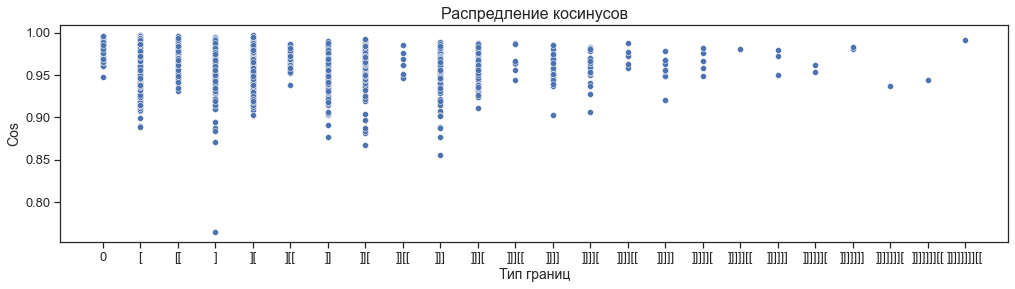

In [146]:
plt.figure(figsize = (17,4))

ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')#color ='#5f7df5')
ax.set_ylabel("Cos", fontsize=14)
ax.set_xlabel("Тип границ", fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=13)
plt.title('Распредление косинусов', fontsize=16)
plt.savefig('scatt.png')
plt.show()

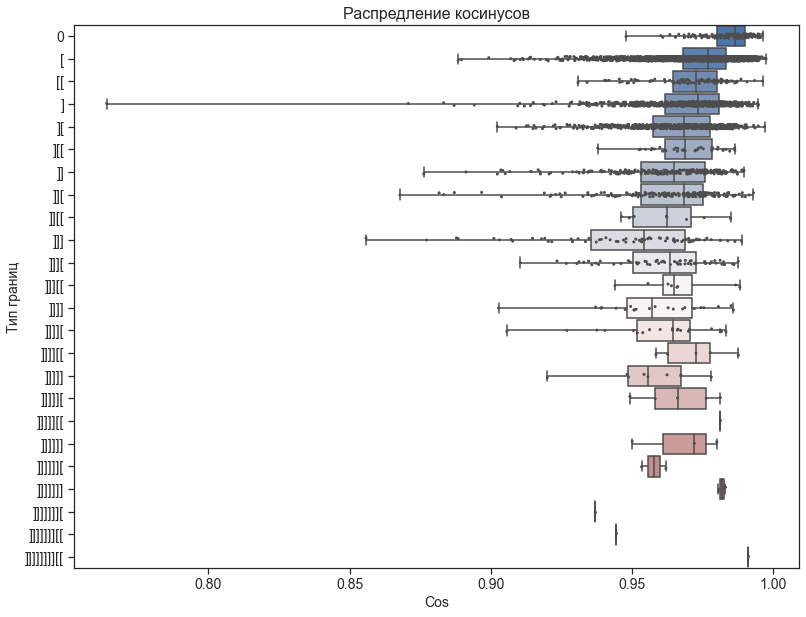

In [147]:
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(13, 10))

sns.boxplot(x="cos", y="bracket_type", data=result,
            whis=[0, 100], width=.9, palette="vlag")

sns.stripplot(x="cos", y="bracket_type", data=result,
              size=3, color=".3", linewidth=0)

plt.xlabel('Cos', fontsize=14);
plt.ylabel('Тип границ', fontsize=14);
plt.title('Распредление косинусов', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('boxplot.png')
plt.show()

In [82]:
inf_for_stats = {}

for bracket in result.bracket_type.unique():
    group = result[result['bracket_type']== bracket]
    if len(group['cos']) >= 20:
        inf_for_stats[bracket] = group['cos']

In [90]:
arr = []
for k1 in inf_for_stats.keys():
    row = []
    for k2 in inf_for_stats.keys():
        row.append(stats.ttest_ind(a=inf_for_stats[k1], b=inf_for_stats[k2], equal_var=False)[1])
    arr.append(row)
        
        

In [93]:
pvalues = np.array(arr)
pvalues

array([[1.00000000e+00, 5.66750386e-29, 1.16769365e-14, 3.09489499e-44,
        2.46030486e-59, 2.59623158e-09, 1.02079130e-38, 8.28449708e-28,
        2.46237883e-16, 1.23338617e-14, 2.02366109e-06, 1.69959027e-05],
       [5.66750386e-29, 1.00000000e+00, 3.61043127e-03, 3.13397308e-13,
        1.42205519e-30, 1.43177422e-02, 3.70552342e-18, 2.39078132e-12,
        5.49002805e-11, 1.23923702e-07, 5.27380869e-04, 3.20680226e-03],
       [1.16769365e-14, 3.61043127e-03, 1.00000000e+00, 5.56890450e-01,
        1.73423970e-02, 8.80653728e-01, 3.39660221e-05, 3.81356443e-04,
        6.07913894e-08, 6.91039456e-04, 8.62313916e-03, 3.76790582e-02],
       [3.09489499e-44, 3.13397308e-13, 5.56890450e-01, 1.00000000e+00,
        2.24944078e-03, 7.62516483e-01, 1.23006596e-06, 1.12584237e-04,
        6.23077765e-08, 6.55117965e-04, 1.18856587e-02, 5.08450763e-02],
       [2.46030486e-59, 1.42205519e-30, 1.73423970e-02, 2.24944078e-03,
        1.00000000e+00, 7.95264562e-02, 2.59545132e-03, 2.30

In [94]:
table = pd.DataFrame(data=pvalues, index=inf_for_stats.keys(), columns=inf_for_stats.keys())
table

,0,[,[[,],][,][[,]],]][,]]],]]][,]]]],]]]][
0,1.000000e+00,5.667504e-29,1.167694e-14,3.094895e-44,2.460305e-59,2.596232e-09,1.020791e-38,8.284497e-28,2.462379e-16,1.233386e-14,0.000002,0.000017
[,5.667504e-29,1.000000e+00,3.610431e-03,3.133973e-13,1.422055e-30,1.431774e-02,3.705523e-18,2.390781e-12,5.490028e-11,1.239237e-07,0.000527,0.003207
[[,1.167694e-14,3.610431e-03,1.000000e+00,5.568904e-01,1.734240e-02,8.806537e-01,3.396602e-05,3.813564e-04,6.079139e-08,6.910395e-04,0.008623,0.037679
],3.094895e-44,3.133973e-13,5.568904e-01,1.000000e+00,2.249441e-03,7.625165e-01,1.230066e-06,1.125842e-04,6.230778e-08,6.551180e-04,0.011886,0.050845
][,2.460305e-59,1.422055e-30,1.734240e-02,2.249441e-03,1.000000e+00,7.952646e-02,2.595451e-03,2.300454e-02,2.001722e-06,2.010166e-02,0.053132,0.175168
][[,2.596232e-09,1.431774e-02,8.806537e-01,7.625165e-01,7.952646e-02,1.000000e+00,7.120263e-04,2.862229e-03,2.706553e-07,2.402718e-03,0.012261,0.049434
]],1.020791e-38,3.705523e-18,3.396602e-05,1.230066e-06,2.595451e-03,7.120263e-04,1.000000e+00,8.042487e-01,4.970394e-04,6.438673e-01,0.364607,0.726993
]][,8.284497e-28,2.390781e-12,3.813564e-04,1.125842e-04,2.300454e-02,2.862229e-03,8.042487e-01,1.000000e+00,4.295672e-04,5.347975e-01,0.316067,0.649740
]]],2.462379e-16,5.490028e-11,6.079139e-08,6.230778e-08,2.001722e-06,2.706553e-07,4.970394e-04,4.295672e-04,1.000000e+00,4.771692e-03,0.097995,0.043044
]]][,1.233386e-14,1.239237e-07,6.910395e-04,6.551180e-04,2.010166e-02,2.402718e-03,6.438673e-01,5.347975e-01,4.771692e-03,1.000000e+00,0.565054,0.944051


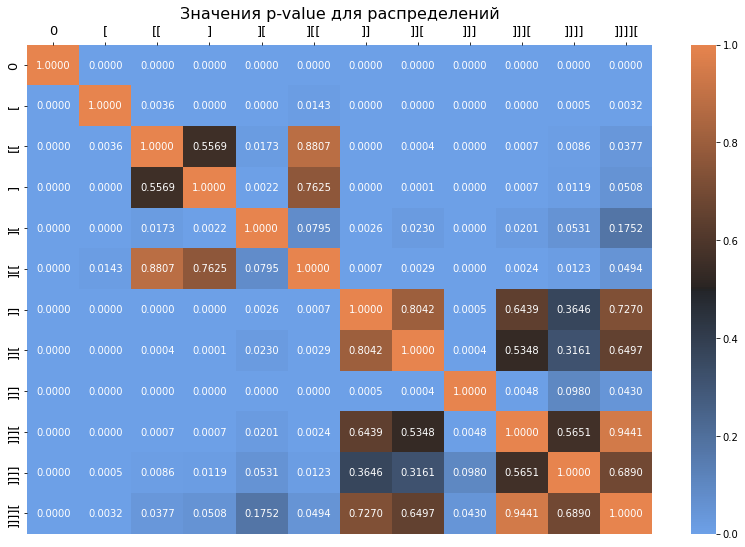

In [108]:
plt.figure(figsize = (14,9))
ax = sns.heatmap(table, annot = True, fmt=".4f", cmap=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True))
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title('Значения p-value для распределений', fontsize=16)
plt.savefig('heatmap.png')
plt.show()